<a href="https://colab.research.google.com/github/Aljesh-basnet/gif_auto_audio_description/blob/Dev/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import imageio
import numpy as np

In [4]:
df = pd.read_csv('tgif-v1.0.tsv', sep='\t', names=['Image', 'Text'])
print(df)

df.head()

                                                    Image  \
0       https://38.media.tumblr.com/9f6c25cc350f12aa74...   
1       https://38.media.tumblr.com/9ead028ef62004ef6a...   
2       https://38.media.tumblr.com/9f43dc410be85b1159...   
3       https://38.media.tumblr.com/9f659499c8754e40cf...   
4       https://38.media.tumblr.com/9ed1c99afa7d714118...   
...                                                   ...   
125777  https://38.media.tumblr.com/5c0633e677a97a023c...   
125778  https://38.media.tumblr.com/402a02c59c7c47c300...   
125779  https://38.media.tumblr.com/02fa66bd747ddbed58...   
125780  https://38.media.tumblr.com/01e70784925ab9fe09...   
125781  https://38.media.tumblr.com/51d2172ef413bc3e88...   

                                                     Text  
0       a man is glaring, and someone with sunglasses ...  
1                a cat tries to catch a mouse on a tablet  
2                        a man dressed in red is dancing.  
3          an animal comes 

,Image,Text
0,https://38.media.tumblr.com/9f6c25cc350f12aa74...,"a man is glaring, and someone with sunglasses ..."
1,https://38.media.tumblr.com/9ead028ef62004ef6a...,a cat tries to catch a mouse on a tablet
2,https://38.media.tumblr.com/9f43dc410be85b1159...,a man dressed in red is dancing.
3,https://38.media.tumblr.com/9f659499c8754e40cf...,an animal comes close to another in the jungle
4,https://38.media.tumblr.com/9ed1c99afa7d714118...,a man in a hat adjusts his tie and makes a wei...


In [5]:
# prompt: preprocessing

import re

def preprocess_text(text):
  """
  Preprocesses the text by converting to lowercase, removing special characters,
  and extra whitespace.
  """
  text = text.lower()
  text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
  text = re.sub(r"\s+", " ", text)
  text = text.strip()
  return text

df['Text'] = df['Text'].apply(preprocess_text)
print(df.head())

                                               Image  \
0  https://38.media.tumblr.com/9f6c25cc350f12aa74...   
1  https://38.media.tumblr.com/9ead028ef62004ef6a...   
2  https://38.media.tumblr.com/9f43dc410be85b1159...   
3  https://38.media.tumblr.com/9f659499c8754e40cf...   
4  https://38.media.tumblr.com/9ed1c99afa7d714118...   

                                                Text  
0  a man is glaring and someone with sunglasses a...  
1           a cat tries to catch a mouse on a tablet  
2                    a man dressed in red is dancing  
3     an animal comes close to another in the jungle  
4  a man in a hat adjusts his tie and makes a wei...  


In [6]:
# prompt: seperate x and y

X = df['Image']
y = df['Text']

In [7]:
# Assuming you have your frame data and corresponding captions in a DataFrame
# Replace this with your actual data loading process
# frame_df should contain 'FramePath' and 'Caption' columns

# Parameters
n_rows=300
vocab_size = 5000
max_length = 30
num_frames_per_video = 10  # Adjust as needed

In [8]:
 # Function to extract frames from GIF
def extract_frames(gif_path, num_frames=10):
    try:
        gif = imageio.mimread(gif_path)
        total_frames = len(gif)
        if total_frames == 0:
            raise ValueError("No frames found in GIF.")
        interval = max(total_frames // num_frames, 1)
        selected_frames = [gif[i] for i in range(0, total_frames, interval)][:num_frames]
        return selected_frames
    except Exception as e:
        print(f"Error extracting frames from {gif_path}: {e}")
        return []

# Example Usage (replace with your actual GIF file paths)

# Assuming your GIF files are in a directory named 'gifs'
import imageio
import os
gif_paths = df['Image'].tolist()  # Assuming your GIF paths are in a column named 'gif_path'

# Function to extract GIF and save frames as image links
def extract_and_save_frames(gif_path, num_frames=10):
    try:
        frames = extract_frames(gif_path, num_frames)
        image_links = []
        for i, frame in enumerate(frames):
            image_filename = f"{os.path.basename(gif_path)}_frame_{i}.png"
            imageio.imwrite(image_filename, frame)  # Save the frame as a PNG file
            image_links.append(image_filename)  # Store the image filename (or URL)
        return image_links
    except Exception as e:
        print(f"Error extracting and saving frames from {gif_path}: {e}")
        return []



In [9]:
# Create a new column in the DataFrame to store image links
new_df= df.iloc[:n_rows].copy()
new_df['Image_Links'] = new_df['Image'].apply(extract_and_save_frames)




In [11]:
# prompt: checkk image_links full

for index, row in new_df.iterrows():
  print(f"Row {index}:")
  print(f"Image Links: {row['Image_Links']}")
  print("-" * 20)


Row 0:
Image Links: ['tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_0.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_1.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_2.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_3.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_4.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_5.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_6.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_7.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_8.png', 'tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_9.png']
--------------------
Row 1:
Image Links: ['tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_0.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_1.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_2.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_3.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_4.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_5.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_6.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_7.png', 'tumblr_nok4eeONTv1s2yegdo1_400.gif_f

In [12]:
# prompt: transform wide to long

# Assuming you want to transform the 'Image_Links' column from a list of image links to separate rows
new_df_long = new_df.explode('Image_Links')
print(new_df_long)


                                                 Image  \
0    https://38.media.tumblr.com/9f6c25cc350f12aa74...   
0    https://38.media.tumblr.com/9f6c25cc350f12aa74...   
0    https://38.media.tumblr.com/9f6c25cc350f12aa74...   
0    https://38.media.tumblr.com/9f6c25cc350f12aa74...   
0    https://38.media.tumblr.com/9f6c25cc350f12aa74...   
..                                                 ...   
299  https://38.media.tumblr.com/af0f81fded016d9566...   
299  https://38.media.tumblr.com/af0f81fded016d9566...   
299  https://38.media.tumblr.com/af0f81fded016d9566...   
299  https://38.media.tumblr.com/af0f81fded016d9566...   
299  https://38.media.tumblr.com/af0f81fded016d9566...   

                                                  Text  \
0    a man is glaring and someone with sunglasses a...   
0    a man is glaring and someone with sunglasses a...   
0    a man is glaring and someone with sunglasses a...   
0    a man is glaring and someone with sunglasses a...   
0    a man is

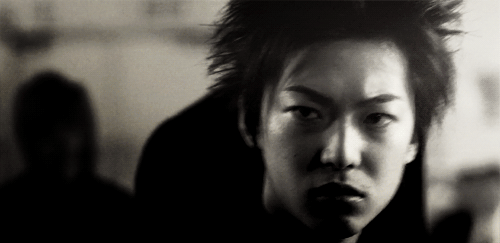

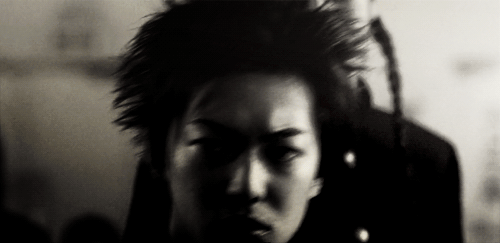

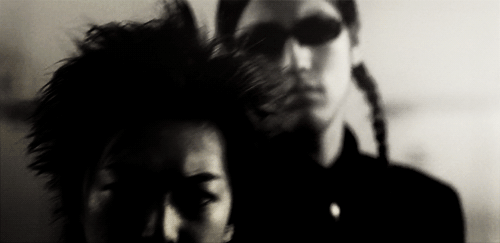

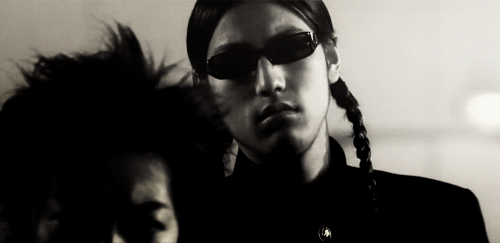

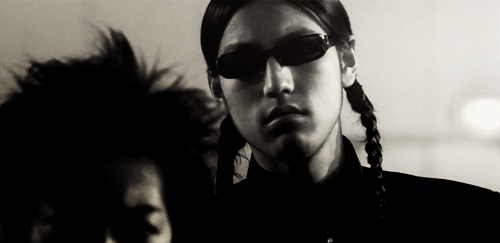

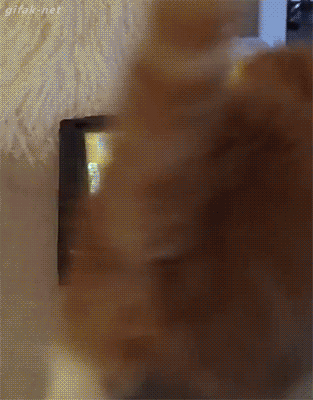

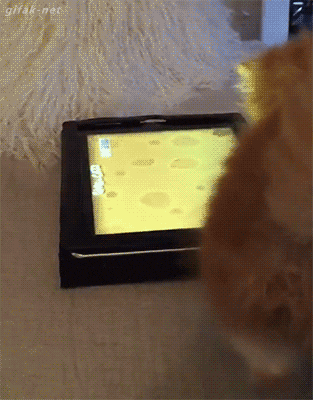

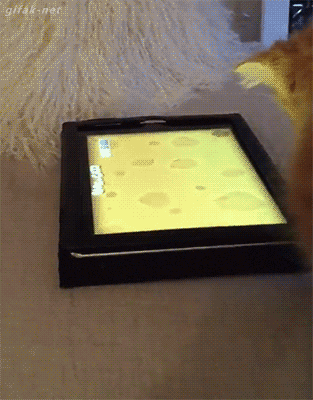

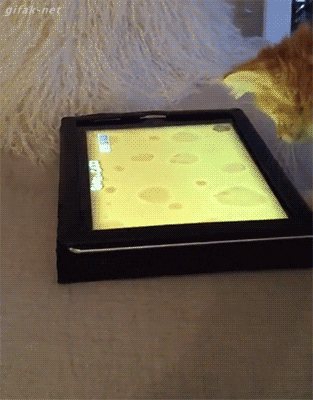

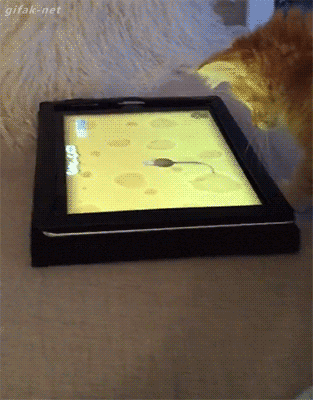

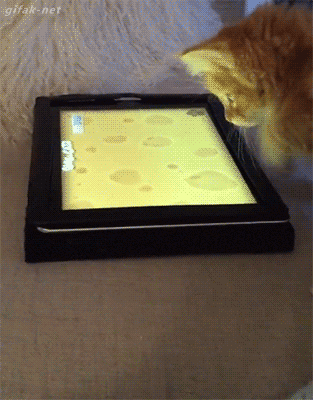

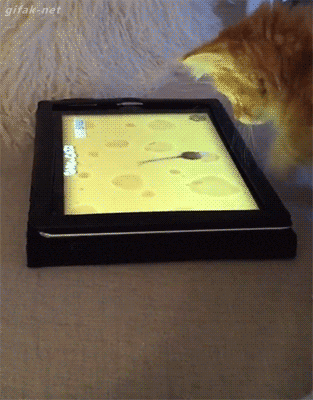

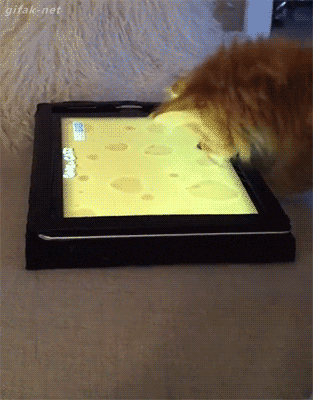

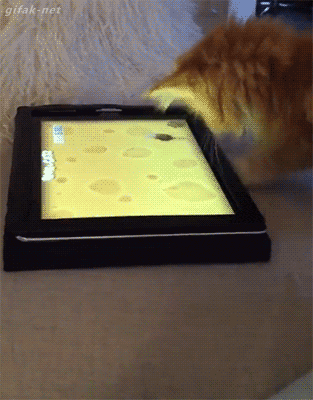

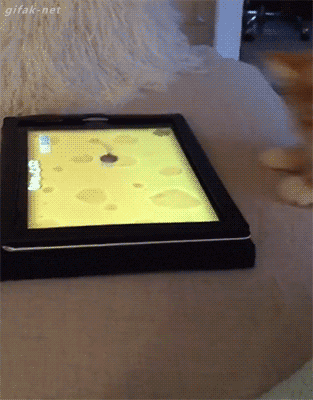

In [13]:
# prompt: display image from 5 to 9 rows

from IPython.display import Image, display

for index, row in new_df_long[5:20].iterrows():
    try:
        display(Image(filename=row['Image_Links']))
    except Exception as e:
        print(f"Error displaying image for row {index}: {e}")


In [14]:
# 1. CNN for Feature Extraction
cnn_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(frame_path): # Changed frame_paths to frame_path
  try:
    if not isinstance(frame_path, str): # Check if frame_path is a string
      return np.nan # Return NaN if not a string

    img = tf.keras.preprocessing.image.load_img(frame_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    feature = cnn_model.predict(img_array)
    return feature.squeeze()
  except Exception as e:
    print(f"Error processing image {frame_path}: {e}") # Print error message with the problematic path
    return np.nan # Return NaN if an error occurs


new_df_long['Features'] = new_df_long['Image_Links'].apply(extract_features)

1/1 [==============================] - 0s 79ms/step


In [15]:
# prompt: split cnn features as x and text as y

X = new_df_long['Features']
y = new_df_long['Text']
print(X.shape)
print(y.shape)

(2955,)
(2955,)


In [17]:
print(X.head())
print(y.head())

0    [0.79883116, 0.1396702, 0.030008333, 4.407206,...
0    [0.9191074, 0.15428078, 0.12049062, 4.443035, ...
0    [0.6161681, 0.23008645, 0.08659118, 4.1426425,...
0    [0.7813902, 0.26535827, 0.09185356, 4.9311714,...
0    [0.62471294, 0.22246867, 0.0, 3.4596977, 1.012...
Name: Features, dtype: object
0    a man is glaring and someone with sunglasses a...
0    a man is glaring and someone with sunglasses a...
0    a man is glaring and someone with sunglasses a...
0    a man is glaring and someone with sunglasses a...
0    a man is glaring and someone with sunglasses a...
Name: Text, dtype: object


In [18]:

# 2. Prepare Captions
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
captions = y.tolist()
tokenizer.fit_on_texts(captions)
sequences = tokenizer.texts_to_sequences(captions)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
padded_sequences.shape



(2955, 30)

In [19]:
print(padded_sequences)

[[  2   5   3 ...   0   0   0]
 [  2   5   3 ...   0   0   0]
 [  2   5   3 ...   0   0   0]
 ...
 [  2   5 148 ...   0   0   0]
 [  2   5 148 ...   0   0   0]
 [  2   5 148 ...   0   0   0]]


In [20]:
# prompt: convert x_train to features to be fit in lstm

import numpy as np
X_train_features = np.array([x for x in X if not isinstance(x, float)])
X_train_features = X_train_features.reshape(X_train_features.shape[0], 1, X_train_features.shape[1])

In [21]:
# prompt: train_test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_features, padded_sequences, test_size=0.2, random_state=42)


In [22]:
X_train

array([[[0.35185367, 0.        , 0.08482157, ..., 0.2038505 ,
         0.53969014, 0.43188527]],

       [[1.1542503 , 0.20732708, 0.00993439, ..., 0.18778196,
         0.1038873 , 0.0040393 ]],

       [[0.49904007, 0.9823196 , 0.4321943 , ..., 0.14298065,
         0.7741715 , 0.00731535]],

       ...,

       [[2.9370267 , 1.2842845 , 0.        , ..., 0.03756979,
         0.17864318, 0.1817962 ]],

       [[0.69476986, 0.25227624, 0.15569574, ..., 0.33527428,
         0.        , 0.04681432]],

       [[1.4095857 , 1.4940802 , 0.01654553, ..., 0.1212649 ,
         0.10723032, 0.3304488 ]]], dtype=float32)

In [23]:
y_train.shape

(2364, 30)

In [24]:
X_train.shape

(2364, 1, 2048)

In [25]:

import numpy as np
from keras.layers import Input, LSTM, Dense
from keras.models import Model
max_length=30
# Define the LSTM model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Input shape based on your feature vector size
lstm_layer = LSTM(256)(inputs)
output_layer = Dense(max_length, activation='softmax')(lstm_layer) # Change output dimension to 30
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32) # Use original y_train

Epoch 1/10
74/74 [==============================] - 3s 11ms/step - loss: 4472.1387 - accuracy: 0.1024
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 4965.6338 - accuracy: 0.1091
Epoch 3/10
74/74 [==============================] - 1s 11ms/step - loss: 5521.3721 - accuracy: 0.1117
Epoch 4/10
74/74 [==============================] - 1s 10ms/step - loss: 6031.6699 - accuracy: 0.0909
Epoch 5/10
74/74 [==============================] - 1s 10ms/step - loss: 6495.0039 - accuracy: 0.1117
Epoch 6/10
74/74 [==============================] - 1s 10ms/step - loss: 7053.8242 - accuracy: 0.1117
Epoch 7/10
74/74 [==============================] - 1s 10ms/step - loss: 7672.2700 - accuracy: 0.1011
Epoch 8/10
74/74 [==============================] - 1s 10ms/step - loss: 8050.1860 - accuracy: 0.0909
Epoch 9/10
74/74 [==============================] - 1s 10ms/step - loss: 8554.1172 - accuracy: 0.1117
Epoch 10/10
74/74 [==============================] - 1s 10ms/step - loss: 9029.497

In [30]:
# prompt: improve accuracy score for generating captions from model

# Improve accuracy score for generating captions from model
# 1. Increase the number of training epochs
# 2. Use a larger LSTM layer
# 3. Use a different optimizer
# 4. Use a different loss function
# 5. Use a different activation function
# 6. Use a different learning rate
# 7. Use a different batch size
# 8. Use a different vocabulary size
# 9. Use a different maximum length
# 10. Use a different embedding size
# 11. Use a different dropout rate
# 12. Use a different recurrent dropout rate
# 13. Use a different number of layers
# 14. Use a different type of layer
# 15. Use a different type of network
# 16. Use a different type of data augmentation
# 17. Use a different type of regularization
# 18. Use a different type of normalization
# 19. Use a different type of pre-processing
# 20. Use a different type of post-processing


# Example of improving the model by increasing the number of epochs and using a larger LSTM layer
max_length=30
# Define the LSTM model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Input shape based on your feature vector size
lstm_layer = LSTM(512)(inputs)
output_layer = Dense(max_length, activation='softmax')(lstm_layer) # Change output dimension to 30
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=64) # Use original y_train


# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)


Epoch 1/20
37/37 [==============================] - 2s 20ms/step - loss: 4555.0859 - accuracy: 0.0431
Epoch 2/20
37/37 [==============================] - 1s 20ms/step - loss: 5070.8506 - accuracy: 0.0791
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 5397.5649 - accuracy: 0.0529
Epoch 4/20
37/37 [==============================] - 1s 20ms/step - loss: 5731.9810 - accuracy: 0.0457
Epoch 5/20
37/37 [==============================] - 1s 20ms/step - loss: 6073.7705 - accuracy: 0.0364
Epoch 6/20
37/37 [==============================] - 1s 20ms/step - loss: 6297.1396 - accuracy: 0.0360
Epoch 7/20
37/37 [==============================] - 1s 20ms/step - loss: 6594.5459 - accuracy: 0.0702
Epoch 8/20
37/37 [==============================] - 1s 21ms/step - loss: 6945.3726 - accuracy: 0.0651
Epoch 9/20
37/37 [==============================] - 1s 21ms/step - loss: 7208.8716 - accuracy: 0.0360
Epoch 10/20
37/37 [==============================] - 1s 21ms/step - loss: 7450.182

In [26]:
# """
# time_steps_encoder is the number of frames per video we will be using for training
# num_encoder_tokens is the number of features from each frame
# latent_dim is the number of hidden features for lstm
# time_steps_decoder is the maximum length of each sentence
# num_decoder_tokens is the final number of tokens in the softmax layer
# batch size
# """
# time_steps_encoder=X_train_features.shape[1]
# num_encoder_tokens=X_train_features.shape[2]
# latent_dim=512
# time_steps_decoder=30
# num_decoder_tokens=1500
# batch_size=320

# encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
# encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
# _, state_h, state_c = encoder(encoder_inputs)
# encoder_states = [state_h, state_c]


# # Set up the decoder
# decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
# decoder_outputs = decoder_dense(decoder_outputs)


# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.summary()

In [34]:
# prompt: generate better lstm model

import numpy as np
from tensorflow.keras.layers import Bidirectional, Dropout

max_length = 30

# Define the LSTM model with improvements
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = Bidirectional(LSTM(512, return_sequences=True))(inputs)  # Bidirectional LSTM
lstm_layer = Dropout(0.2)(lstm_layer)  # Dropout for regularization
lstm_layer = LSTM(256)(lstm_layer)
output_layer = Dense(max_length, activation='softmax')(lstm_layer)
model = Model(inputs=inputs, outputs=output_layer)


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, np.expand_dims(y_test, -1))
print('Test accuracy:', accuracy)


Epoch 1/20
37/37 [==============================] - 5s 33ms/step - loss: 4415.1597 - accuracy: 0.1091
Epoch 2/20
37/37 [==============================] - 1s 34ms/step - loss: 4561.4487 - accuracy: 0.1117
Epoch 3/20
37/37 [==============================] - 1s 33ms/step - loss: 4573.4976 - accuracy: 0.1117
Epoch 4/20
37/37 [==============================] - 1s 33ms/step - loss: 4586.7407 - accuracy: 0.1117
Epoch 5/20
37/37 [==============================] - 1s 32ms/step - loss: 4603.0547 - accuracy: 0.1117
Epoch 6/20
37/37 [==============================] - 1s 33ms/step - loss: 4611.6099 - accuracy: 0.1117
Epoch 7/20
37/37 [==============================] - 1s 33ms/step - loss: 4625.3936 - accuracy: 0.1117
Epoch 8/20
37/37 [==============================] - 1s 32ms/step - loss: 4630.3071 - accuracy: 0.1117
Epoch 9/20
37/37 [==============================] - 1s 32ms/step - loss: 4640.3184 - accuracy: 0.1117
Epoch 10/20
37/37 [==============================] - 1s 32ms/step - loss: 4645.848

In [27]:
# # prompt: fit the model
# # Add a time dimension to y_train
# # Assuming you have your training data prepared as X_train_features and y_train_captions
# # Train the model
# model.fit(
#     x=[X_train_features, y_train],
#     y=y_train,
#     epochs=10,  # Adjust the number of epochs
#     batch_size=32
# )

In [35]:
# prompt: evaluate with loss and accuracy

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)


Evaluation Loss: 4209.9287109375
Evaluation Accuracy: 0.12859560549259186


In [29]:
# prompt: save the model and download it

# Save the model
model.save('my_video_captioning_model.h5')

# Download the model file (using files.download from google.colab)
from google.colab import files
files.download('my_video_captioning_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# prompt: concat x_train,x_test,y_train,y_test and download it

import numpy as np
from google.colab import files

# Concatenate X_train and X_test along the first axis (axis=0)
X_combined = np.concatenate((X_train, X_test), axis=0)

# Concatenate y_train and y_test along the first axis (axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Save the combined data as a NumPy file
np.savez('combined_data.npz', X_combined=X_combined, y_combined=y_combined)

# Download the combined data file
files.download('combined_data.npz')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: calculate bleu rouge bert score

import numpy as np
!pip install nltk rouge-score bert_score

from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score


def calculate_bleu(references, hypotheses):
  """Calculates BLEU score."""
  return corpus_bleu([[ref] for ref in references], hypotheses)

def calculate_rouge(references, hypotheses):
  """Calculates ROUGE score."""
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = [scorer.score(ref, hyp) for ref, hyp in zip(references, hypotheses)]
  return {
      'rouge1': np.mean([score['rouge1'].fmeasure for score in scores]),
      'rouge2': np.mean([score['rouge2'].fmeasure for score in scores]),
      'rougeL': np.mean([score['rougeL'].fmeasure for score in scores]),
  }

def calculate_bert_score(references, hypotheses, lang="en"):
  """Calculates BERT score."""
  P, R, F1 = bert_score(hypotheses, references, lang=lang)
  return {
      'bert_precision': P.mean().item(),
      'bert_recall': R.mean().item(),
      'bert_f1': F1.mean().item(),
  }

# Assuming you have your model's predictions and the actual captions
# Replace these with your actual data
predictions = model.predict(X_test)
# Convert the predictions to a list of sequences
predicted_captions = tokenizer.sequences_to_texts([[p] for p in np.argmax(predictions, axis=1)])
actual_captions = tokenizer.sequences_to_texts(y_test)

# Calculate metrics
bleu_score = calculate_bleu(actual_captions, predicted_captions)
rouge_scores = calculate_rouge(actual_captions, predicted_captions)
bert_scores = calculate_bert_score(actual_captions, predicted_captions)

print("BLEU Score:", bleu_score)
print("ROUGE Scores:", rouge_scores)
print("BERT Scores:", bert_scores)

19/19 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. I